# LSTM
Long Short-Term Memory

In [12]:
import glob
import os
from pathlib import Path
from scipy.io import wavfile

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
# Dataset
from torch.utils.data import DataLoader, Dataset, random_split

import librosa
import librosa.display
import IPython.display as ipd

from tqdm.notebook import tqdm
# from google_drive_downloader import GoogleDriveDownloader as gdd

## AudioDataset Class

In [13]:
sliced_dataset = "short_audio_dataset"
sliced_dataset_lenght = 16050
# sliced_dataset = "shorter_audio_dataset"
# sliced_dataset_lenght = 4013
original_dataset = "audio_dataset"
original_dataset_lenght = 80249

class AudioDataset(Dataset):
    def __init__(self, root_path="./data/", drop_both=False, use_short=False, normalize=False, use_features=False):
        root_folder = root_path + original_dataset if not use_short else root_path + sliced_dataset
        self.use_features = use_features
        self.max_length = original_dataset_lenght if not use_short else sliced_dataset_lenght
        self.class_map = {"esben" : 0, "peter": 1, "both": 2}
        self.data = []
        self.wavs = []
        self.labels = []
        self.features_list = []
        self.min_val = 10e10
        self.max_val = 0
        print("Start reading files")
        for subdir, dirs, files in os.walk(root_folder):
            for file_name in files:
                if drop_both and "both" in subdir:
                   continue
        
                file_path = os.path.join(subdir, file_name)
                self.sample_rate, wav = wavfile.read(file_path)
                wav = wav.astype(np.float32)
                
                if wav.shape[0] > self.max_length:
                    self.max_length = wav.shape[0]
                    print("Found wav with more length than specified max one, new max is:", wav.shape[0])
                
                wav = np.pad(wav, (0, self.max_length-wav.shape[0]))
                features = np.transpose(self.feature_extraction(wav, self.sample_rate, normalize=normalize))
                label_str = file_path.split('/')[-3][2:]
                label = (np.int64(self.class_map[label_str]))
                
                self.max_val = np.max(wav) if np.max(wav) > self.max_val else self.max_val
                self.min_val = np.min(wav) if np.min(wav) < self.min_val else self.min_val
                
                self.wavs.append(wav)
                self.features_list.append(features)
                self.labels.append(label)
               
        self.wavs = np.array(self.wavs)
        self.mu  = self.wavs.mean()
        self.std = np.std(self.wavs)
        # self.wavs = torch.Tensor(self.wavs)
        if normalize:
            self.wavs = (self.wavs + np.abs(self.min_val)) / (np.abs(self.min_val) + self.max_val)
            # self.wavs = torch.nn.functional.normalize(self.wavs, dim=1)
        
        print("="*40)
        print("Loaded DATABASE from {}\n{} total file\nLongest file is {} long\nMean: {}\nStandard deviation: {}\nNormalization: {}".
              format(root_folder, len(self.wavs), self.max_length, self.mu, self.std, normalize))
        print("="*40)
    
    def feature_extraction(self, wav, sample_rate, n_mfcc=128, normalize=False):
        # extract features from the audio
        mfcc = np.mean(librosa.feature.mfcc(y=wav, sr=sample_rate, n_mfcc=n_mfcc).T, axis=0)
        if normalize:
            mfcc = (mfcc + np.abs(np.min(mfcc))) / (np.abs(np.min(mfcc)) + np.max(mfcc))
        return mfcc

    def __len__(self):
        return len(self.wavs)
    
    def __getitem__(self, idx):
        wav = self.wavs[idx]
        label = self.labels[idx]
        wav_tensor = torch.from_numpy(wav)
        # label_tensor = torch.Tensor(label)
        if self.use_features:
            features = self.features_list[idx]
            features_tensor = torch.Tensor(features)
            return features_tensor, label
        return wav_tensor, label


Data Generation

In [14]:
# Load data

audio_dataset = AudioDataset(root_path="../data/", drop_both=True, use_short=True, normalize=True, use_features=True)
dataset_len = len(audio_dataset)
train_size, test_size, valid_size = int(dataset_len * 0.7), int(dataset_len * 0.2), int(dataset_len * 0.1)

dataset_train, dataset_test, dataset_valid = torch.utils.data.random_split(audio_dataset, (train_size, test_size, valid_size))

kwargs = {'batch_size': 1, 'num_workers': 2}
loader_train = torch.utils.data.DataLoader(dataset_train, **kwargs, shuffle=True)
loader_test = torch.utils.data.DataLoader(dataset_test, **kwargs, shuffle=True)
loader_valid = torch.utils.data.DataLoader(dataset_valid, **kwargs, shuffle=True)

# 33% should be considered like with the other methods 
# In the solution he plots the lengths of the data...but thats just for educational purpose so I didn't reuse that

Start reading files
Loaded DATABASE from ../data/short_audio_dataset
1000 total file
Longest file is 16050 long
Mean: -0.6988561153411865
Standard deviation: 2332.388427734375
Normalization: True


**Task**

* Create a class to load the dataset
    * To be able to batch emails, they have to have the same length. You can ensure this in different ways e.g. zero-padding
    * Make a training and validation set based on *emails_ascii* and *targets*  
* Create and train a recurrent model to classify whether the emails are spam or not
    * Have a look at the [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) module and the [Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) module

To be able to batch-process the mails even though some of the mails are shorter than the chosen text-length, the dataset zero-pads the text and returns an index for the last valid character.

In [15]:
class voiceClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(voiceClassifier, self).__init__()  
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True) # Long Short Term Memory Layer -> 
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()  # For binary classification

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) # initial hiddens
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) # initial cell states

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # Output shape: (batch_size, seq_length, hidden_size)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        output = self.sigmoid(out)  # Sigmoid for binary classification
        return output

In [33]:
input_size = 128  # I think this is the size of our features
hidden_size = 128  # Choose an appropriate size
num_layers = 1  # Number of LSTM layers
output_size = 1  # For binary classification
model = voiceClassifier(input_size, hidden_size, num_layers, output_size)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
sched = torch.optim.lr_scheduler.MultiStepLR(opt, (30,))

train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
lrs = []


pbar = tqdm(range(40))
for epoch in pbar:
    # Train
    model.train()
    losses=[]
    #train_losses = []
    train_correct = 0
    train_total = 0
    for x, y in loader_train:
        opt.zero_grad()
        x = x.unsqueeze(0)  # Add a batch dimension assuming it's a single sequence
        y = y.unsqueeze(1)
        output = model(x)
        loss = F.binary_cross_entropy_with_logits(output, y.float())
        loss.backward()
        opt.step()
        losses.append(loss.item())
        #train_losses.append(loss.item())
        train_total += y.size(0)
        train_correct += ((output > 0.5) == y.byte()).sum().item()
   
    train_loss = np.mean(losses) #added from old
    train_accuracy = train_correct / train_total
    avg_train_loss = sum(losses) / len(losses)
    
    # Validation
    model.eval()
    losses = []
    #valid_losses = []
    valid_correct = 0
    valid_total = 0
    with torch.no_grad():
        for x, y in loader_valid:
            x = x.unsqueeze(0)  # Add a batch dimension assuming it's a single sequence
            y = y.unsqueeze(1)
            output = model(x)
            loss = F.binary_cross_entropy(output, y.float())
            losses.append(loss.item())
            #valid_losses.append(loss.item())
            valid_total += y.size(0)
            valid_correct += ((output > 0.5) == y.byte()).sum().item()
            
    valid_loss = np.mean(losses) # added from old
    valid_accuracy = valid_correct / valid_total
    avg_valid_loss = sum(losses) / len(losses)

    # sched
    sched.step()

    # history
    lrs.append(next(iter(opt.param_groups))['lr'])

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)


    print(f"Epoch [{epoch + 1}/40], "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Valid Loss: {avg_valid_loss:.4f}, Valid Acc: {valid_accuracy:.4f}")

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1/40], Train Loss: 0.7048, Train Acc: 0.4914, Valid Loss: 1.2882, Valid Acc: 0.5000
Epoch [2/40], Train Loss: 0.6945, Train Acc: 0.4986, Valid Loss: 1.8611, Valid Acc: 0.5000
Epoch [3/40], Train Loss: 0.6935, Train Acc: 0.4986, Valid Loss: 2.0515, Valid Acc: 0.5000
Epoch [4/40], Train Loss: 0.6932, Train Acc: 0.4986, Valid Loss: 1.9725, Valid Acc: 0.5000
Epoch [5/40], Train Loss: 0.6925, Train Acc: 0.4986, Valid Loss: 1.4014, Valid Acc: 0.5000
Epoch [6/40], Train Loss: 0.6851, Train Acc: 0.5057, Valid Loss: 0.7526, Valid Acc: 0.5700
Epoch [7/40], Train Loss: 0.6642, Train Acc: 0.5957, Valid Loss: 1.0008, Valid Acc: 0.5600
Epoch [8/40], Train Loss: 0.6355, Train Acc: 0.6900, Valid Loss: 0.5954, Valid Acc: 0.6900
Epoch [9/40], Train Loss: 0.6096, Train Acc: 0.7814, Valid Loss: 0.3443, Valid Acc: 0.8400
Epoch [10/40], Train Loss: 0.5934, Train Acc: 0.8186, Valid Loss: 0.2662, Valid Acc: 0.8800
Epoch [11/40], Train Loss: 0.5855, Train Acc: 0.8357, Valid Loss: 0.2229, Valid Acc: 0.90

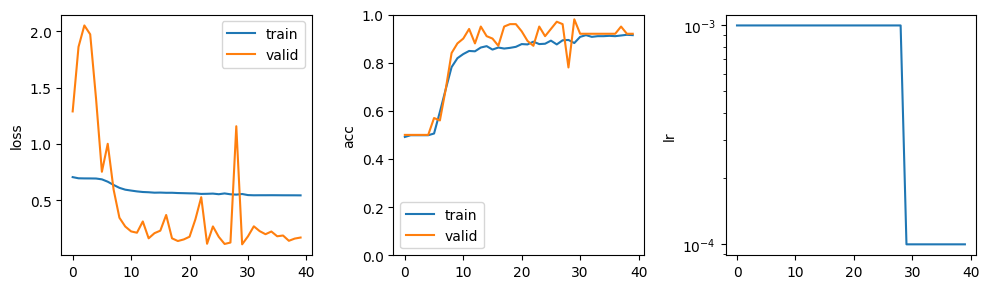

In [35]:
# plot history
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
axs[0].plot(train_losses, label='train')
axs[0].plot(valid_losses, label='valid')
            
axs[0].set_ylabel('loss')
axs[0].legend()
axs[1].plot(train_accuracies, label='train')
axs[1].plot(valid_accuracies, label='valid')
axs[1].set_ylabel('acc')
axs[1].set_ylim(0, 1)
axs[1].legend()
axs[2].plot(lrs)
axs[2].set_ylabel('lr')
axs[2].set_yscale('log')
plt.tight_layout()
plt.show()